# Восстановление золота из руды

Текущее исследование проводится на основе данных, которые были получены при двухэтапной очистке золотонесущей руды на неком предприятии.  

Цель исследования -- построить и обучить на имеющихся данных модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды.  
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  

В ходе работы следует:

1. Изучить данные из трех файлов:
    - gold_industry_train.csv — обучающая выборка
    - gold_industry_test.csv — тестовая выборка
    - gold_industry_full.csv — исходные данные  
Данные индексируются датой и временем получения информации (признак date)  
Соседние по времени параметры часто похожи
2. Проверить расчет эффективности обогащения по формуле:

$$RECOVERY=\frac{C*(F-T)}{F*(C-T)}*100\%,$$
где:
   - $C$ — доля золота в концентрате после флотации/очистки
   - $F$ — доля золота в сырье/концентрате до флотации/очистки
   - $T$ — доля золота в отвальных хвостах после флотации/очистки
3. Проанализировать признаки, которые недоступны в тестовой выборке, и завершить предобработку данных
4. Проанализировать концентрацию металлов и размер гранул на различных этапах
5. Построить модель для вычисления итоговой sMAPE по формуле:
$$sMAPE=\frac{1}{N}\sum_{i=1}^{N}\frac{|y_i-\widehat{y_i}|}{(|y_i|+|\widehat{y_i}|)/2}*100\%,$$
где:
   - $y_i$ — значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество  
   - $\widehat{y_i}$ — значение предсказания для объекта с порядковым номером i, например, в тестовой выборке  
   - $N$ — количество объектов в выборке
   
  
$$Итоговое\ sMAPE=25\%*sMAPE(rougher)\ +\ 75\%*sMAPE(final),$$
    где:
   - $rougher$ — эффективность обогащения чернового концентрата
   - $final$ — эффективность финального чернового концентрата
6. Подготовить общий вывод  

**Наименование признаков**  
Наименование признаков должно быть такое:  
    **[этап].[тип_параметра].[название_параметра]**  
Пример: rougher.input.feed_ag
   - Возможные значения для блока [этап]:
     + rougher — флотация
     + primary_cleaner — первичная очистка
     + secondary_cleaner — вторичная очистка
     + final — финальные характеристики
   - Возможные значения для блока [тип_параметра]:
     + input — параметры сырья
     + output — параметры продукта
     + state — параметры, характеризующие текущее состояние этапа
     + calculation — расчётные характеристики

Для начала определим глобальные переменные и подключим необходимые библиотеки:
_________________

In [1]:
import pandas as pd
import numpy as np
import warnings 
import time 

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score

from sklearn.dummy import DummyRegressor

In [2]:
# Общие константы:
MODE = '' 
MODE = 'check' 
# Константа-рычаг для проверки работы. Включает оптимальные гиперпараметры для случайного леса и решающего дерева. 
# Если закомментить, то будет включен перерасчет. Встретится при вызове функций train_for_rmse и train_for_rmse_scorer. 
# MODE = 'check' -- включено.
# Всё остальное -- выключено.

RAND_FIX = 12345 # Зафиксируем random_state

In [3]:
warnings.filterwarnings('ignore') # отключаем предупреждения

## Шаг 1 Подготовка данных

### 1.1 Открытие и изучение данных

In [4]:
try:
    d_gold_train = pd.read_csv('datasets/gold_industry_train.csv', sep=',') # загружаем с локального хранилища
    d_gold_test = pd.read_csv('datasets/gold_industry_test.csv', sep=',')
    d_gold_full = pd.read_csv('datasets/gold_industry_full.csv', sep=',')
    
    print('*' * 50, 'Тренировочная выборка', sep='\n')
    display(d_gold_train.head(5))
    print()
    d_gold_train.info()
    print('*' * 50, 'Тестовая выборка', sep='\n')
    display(d_gold_test.head(5))
    print()
    d_gold_test.info()
    print('*' * 50, 'Исходный датасет', sep='\n')
    display(d_gold_full.head(5))
    print()
    d_gold_full.info()
except:
    d_gold_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv', sep=',') # если что-то не выходит,
    d_gold_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv', sep=',') # то с Яндекса
    d_gold_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv', sep=',')
    
    print('Файл загружен из хранилища Яндекс')
    print('*' * 50, 'Тренировочная выборка', sep='\n')
    display(d_gold_train.head(5))
    print()
    d_gold_train.info()
    print('*' * 50, 'Тестовая выборка', sep='\n')
    display(d_gold_test.head(5))
    print()
    d_gold_test.info()
    print('*' * 50, 'Исходный датасет', sep='\n')
    display(d_gold_full.head(5))
    print()
    d_gold_full.info()

**************************************************
Тренировочная выборка


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.sta

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64

Посмотрим обзорно распределения величин на полной выборке:

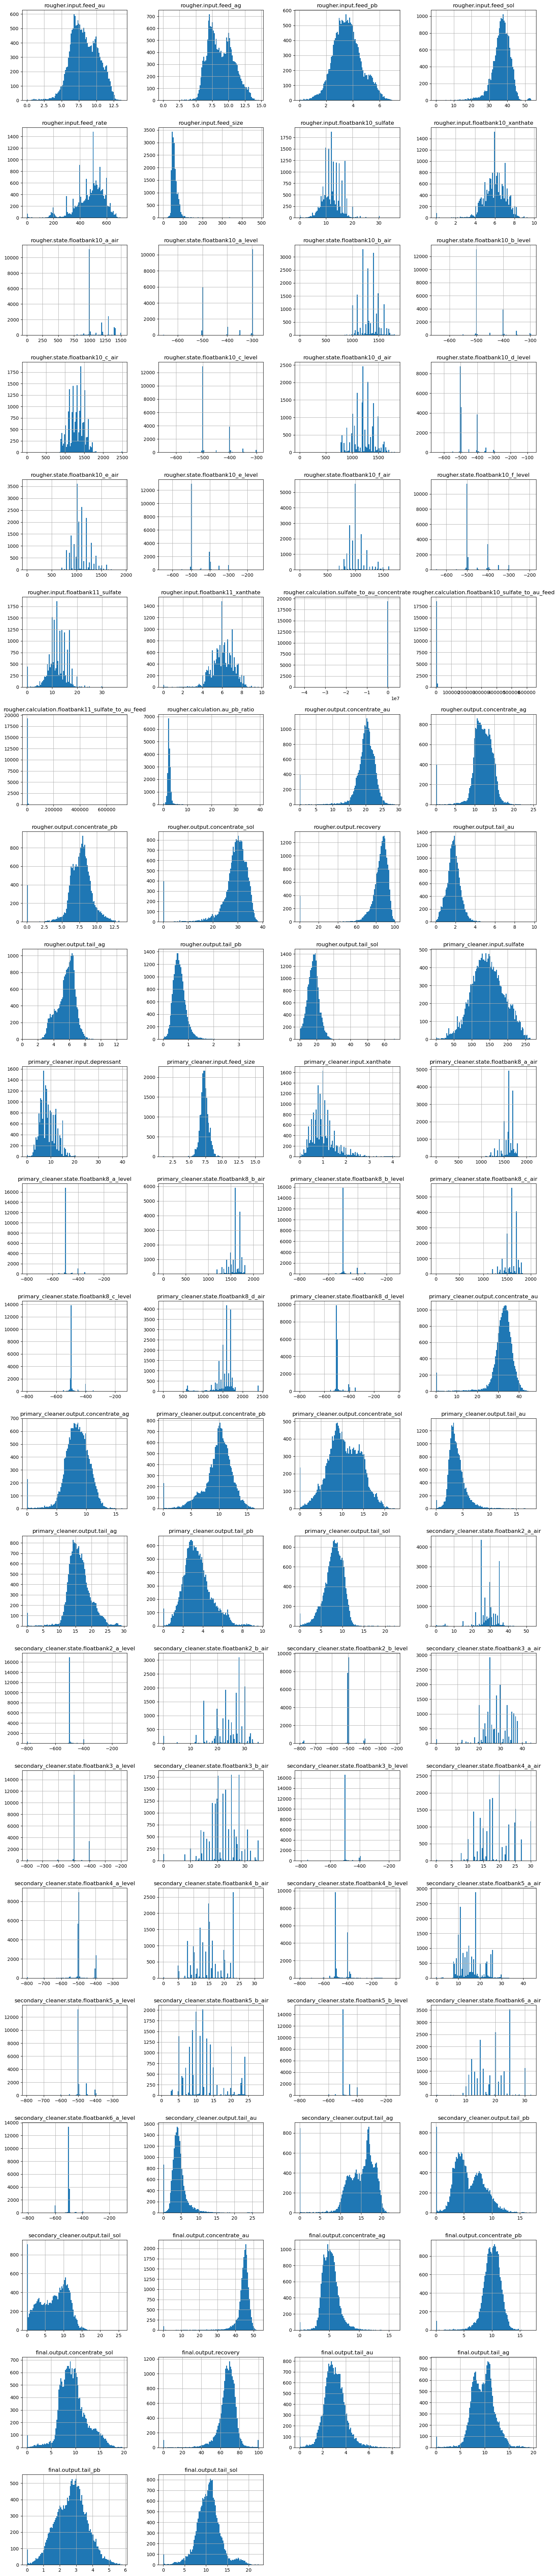

In [5]:
d_gold_full.drop('date', axis=1).hist(figsize=(20, 100), rwidth=1, layout=(22, 4), bins=100);

Промежуточные выводы:
1. Наименования столбцов соответствуют описанию в постановке
2. Встречаются пропущенные значения, но немного -- самое большое 8,99% для secondary_cleaner.output.tail_sol.  
Но тут нам поможет информация из Постановки "Соседние по времени параметры часто похожи", поэтому сможем интерполировать по соседним по времени параметрам
3. Необходимо также будет:
    - проверить на дубликаты по date
    - перевести date в тип datetime
    - исследовать разницу признаков в тренировочной и общей выборках
    - проверить данные на корреляцию
4. Соотношение тестовой и обучающей выборок -- 75 к 25, сумма строк их (14579 + 4860 = 19439) совпадает с количеством строк в полной выборке, но нужно будет проверить еще и по контенту

### 1.2 Предобработка

#### 1.2.1 Проверка правильности расчета эффективности обогащения 

На обучающей выборке вычислим **RECOVERY** и сравним с **d_gold_train['rougher.output.recovery']** с помощью оценки средней абсолютной ошибки:

In [6]:
d_gold_train['rougher.output.manual_recovery'] = \
(d_gold_train['rougher.output.concentrate_au'] * (d_gold_train['rougher.input.feed_au'] - d_gold_train['rougher.output.tail_au'])) / \
(d_gold_train['rougher.input.feed_au'] * (d_gold_train['rougher.output.concentrate_au'] - d_gold_train['rougher.output.tail_au'])) \
*100

print('Cредняя абсолютная ошибка между имеющимися и рассчитанными данными равна:', \
      mean_absolute_error(d_gold_train['rougher.output.manual_recovery'], d_gold_train['rougher.output.recovery']))

d_gold_train = d_gold_train.drop('rougher.output.manual_recovery', axis=1)

Cредняя абсолютная ошибка между имеющимися и рассчитанными данными равна: 9.83758577644259e-15


MAE получилась достаточно незначительной для того, чтоб утверждать, что расчет эффективности обогащения корректен.

#### 1.2.2 Изменение типов

Поменяем только date (object -> datetime64):

In [7]:
d_gold_train['date'] = pd.to_datetime(d_gold_train['date'], format='%Y-%m-%d %H:%M:%S')
d_gold_test['date'] = pd.to_datetime(d_gold_test['date'], format='%Y-%m-%d %H:%M:%S')
d_gold_full['date'] = pd.to_datetime(d_gold_full['date'], format='%Y-%m-%d %H:%M:%S')
print("Тип d_gold_train['date'] --", d_gold_train['date'].dtypes)
print("Тип d_gold_test['date'] --", d_gold_test['date'].dtypes)
print("Тип d_gold_full['date'] --", d_gold_full['date'].dtypes)

Тип d_gold_train['date'] -- datetime64[ns]
Тип d_gold_test['date'] -- datetime64[ns]
Тип d_gold_full['date'] -- datetime64[ns]


Успешно, идем дальше

#### 1.2.3 Проверка на дубликаты

In [8]:
print('Количество дублей в d_gold_train.date --', d_gold_train['date'].duplicated().sum())
print('Количество дублей в d_gold_test.date --', d_gold_test['date'].duplicated().sum())
print('Количество дублей в d_gold_full.date --', d_gold_full['date'].duplicated().sum())

Количество дублей в d_gold_train.date -- 0
Количество дублей в d_gold_test.date -- 0
Количество дублей в d_gold_full.date -- 0


Дублей по индексирующему столбцу нет, идем дальше.

#### 1.2.4 Анализ наборов признаков

Выделим два подмножества столбцов:
1. **intresec_col** -- столбцы, которые есть и в d_gold_test, и в d_gold_full
2. **diff_col** -- столбцы, которые есть в d_gold_full, но которых нет в d_gold_test

In [9]:
intersec_col = []
diff_col = []

for i in d_gold_full.columns:
    if i in d_gold_test.columns:
        intersec_col.append(i)
    else:
        diff_col.append(i)

print('Столбцы, которые есть во всех выборках:')
display(pd.Series(intersec_col))
print('Столбцы, которых не хватает в тестовой выборке:')
display(pd.Series(diff_col))

Столбцы, которые есть во всех выборках:


0                                           date
1                          rougher.input.feed_au
2                          rougher.input.feed_ag
3                          rougher.input.feed_pb
4                         rougher.input.feed_sol
5                        rougher.input.feed_rate
6                        rougher.input.feed_size
7              rougher.input.floatbank10_sulfate
8             rougher.input.floatbank10_xanthate
9                rougher.state.floatbank10_a_air
10             rougher.state.floatbank10_a_level
11               rougher.state.floatbank10_b_air
12             rougher.state.floatbank10_b_level
13               rougher.state.floatbank10_c_air
14             rougher.state.floatbank10_c_level
15               rougher.state.floatbank10_d_air
16             rougher.state.floatbank10_d_level
17               rougher.state.floatbank10_e_air
18             rougher.state.floatbank10_e_level
19               rougher.state.floatbank10_f_air
20             rough

Столбцы, которых не хватает в тестовой выборке:


0         rougher.calculation.sulfate_to_au_concentrate
1     rougher.calculation.floatbank10_sulfate_to_au_...
2     rougher.calculation.floatbank11_sulfate_to_au_...
3                       rougher.calculation.au_pb_ratio
4                         rougher.output.concentrate_au
5                         rougher.output.concentrate_ag
6                         rougher.output.concentrate_pb
7                        rougher.output.concentrate_sol
8                               rougher.output.recovery
9                                rougher.output.tail_au
10                               rougher.output.tail_ag
11                               rougher.output.tail_pb
12                              rougher.output.tail_sol
13                primary_cleaner.output.concentrate_au
14                primary_cleaner.output.concentrate_ag
15                primary_cleaner.output.concentrate_pb
16               primary_cleaner.output.concentrate_sol
17                       primary_cleaner.output.

Очевидно, что из тестовой выборки пропали признаки с типом параметра **output**, которые характеризуют состояние продукта на выходе этапа и признаки с типом параметра **calculation**, для расчета которых, судя по всему, необходимы отсутствующие значения output.  
То есть:
- rougher.output...
- rougher.calculation...
- primary_cleaner.output...
- secondary_cleaner.output...
- final.output...

**NB!** Отмечу особо, что в тестовой выборке нет целевых признаков: final.output.recovery и rougher.output.recovery.
Рассчитать мы их тоже не сможем, так как rougher.output.tail_au или rougher.output.concentrate_au, например, отсутствуют.  
Похоже, придется воспользоваться d_gold_full в качестве донора.

Поэтому, посмотрим на этот датафрейм более пристально:

#### 1.2.5 Анализ соотношения трех датафреймов

Проверим, корерктно ли обращаться к объединенному датафрейму d_gold_full.  
Для этого сверим:
1. Совмещенные датафреймы d_gold_train и d_gold_test и датафрейм d_gold_full с ограничением по столбцам d_gold_train
2. Датафрейм d_gold_train и d_gold_full с ограниченим по строкам d_gold_train

In [10]:
# Первая проверка: конкатенируем датафреймы d_gold_train и d_gold_test, выравниваем всё по возрастанию дат, обновляем индексы:
d_gold_concat = pd.concat([d_gold_train[intersec_col], d_gold_test])
d_gold_concat = d_gold_concat.sort_values(by='date').reset_index(drop=True)
d_gold_full = d_gold_full.sort_values(by='date').reset_index(drop=True)
d_gold_full[intersec_col].equals(d_gold_concat)

True

In [11]:
# Вторая проверка: ограничиваем d_gold_full, сравниваем его с отсортированным d_gold_train:
d_gold_full.loc[d_gold_full.date.isin(d_gold_train.date), :].equals(d_gold_train.sort_values(by='date').reset_index(drop=True))

True

В обоих случаях совпадение -- датафрейму d_gold_full можно доверять, никакие данные не потерялись

#### 1.2.6 Заполненние недостающих значений

Как и планировали в 1.1:
1. Сортируем датафреймы по дате (d_gold_full уже отсортирован)
2. Применяем pandas.DataFrame.interpolate для заполнения пропущенных значений (method='linear')
3. Нам повезло -- будущие целевые признаки заполнены, их не трогаем

In [12]:
d_gold_train = d_gold_train.sort_values(by='date').reset_index(drop=True).interpolate()
d_gold_test = d_gold_test.sort_values(by='date').reset_index(drop=True).interpolate()
d_gold_full = d_gold_full.interpolate()

In [13]:
print('Количество пустых значений в d_gold_train:', d_gold_train.isna().sum().sum())
print('Количество пустых значений в d_gold_test:', d_gold_test.isna().sum().sum())
print('Количество пустых значений в d_gold_full:', d_gold_full.isna().sum().sum())

Количество пустых значений в d_gold_train: 0
Количество пустых значений в d_gold_test: 0
Количество пустых значений в d_gold_full: 0


#### 1.2.7 Корреляция признаков

Рассмотрим признаки из тестовой выборки -- нам на них учиться.  
Посмотрим, есть ли такие, которые имеют высокий к-т корреляции 

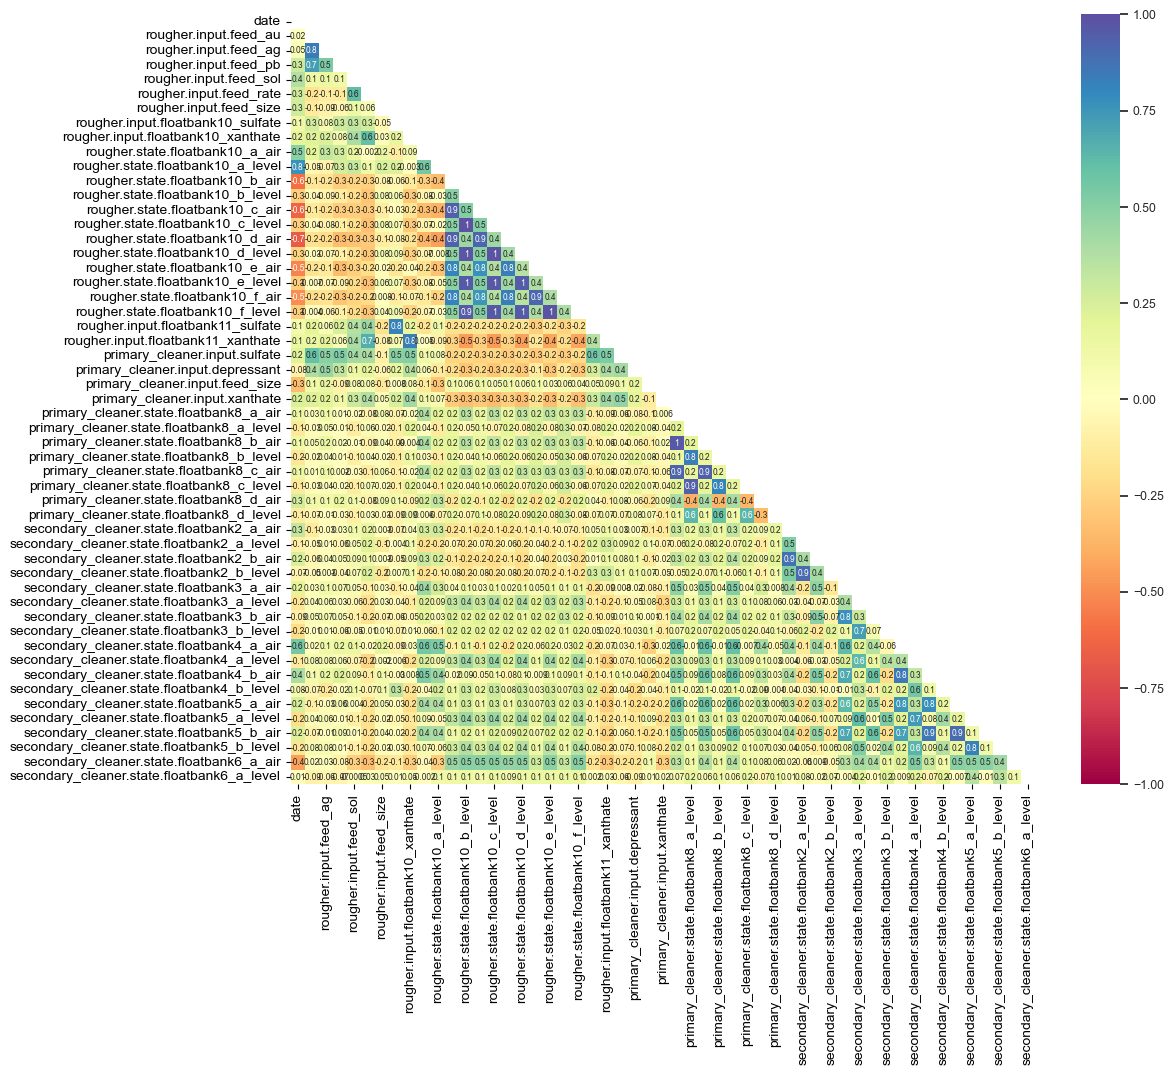

In [14]:
fig, ax = plt.subplots(figsize=(12,10)) 
sns.set (font_scale= 0.8)
matrix = np.triu(d_gold_train[intersec_col].corr())
sns.heatmap(d_gold_train[intersec_col].corr(), cmap= 'Spectral', ax=ax, annot = True, fmt='.1g', mask=matrix, \
            vmin=-1, vmax=1, center= 0, annot_kws={"fontsize":6});

Есть признаки, которые имеют сильную зависимость.

Попробуем удалить столбцы с к-тами 0.9 - 1. Если я правильно помню, то это позволит нам не попасть в ловушку фиктивных признаков.

In [15]:
train_col=set(intersec_col)-set(['rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_e_level', \
                                 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_c_level', \
                                 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_c_air', \
                                'primary_cleaner.state.floatbank8_c_level', 'rougher.state.floatbank10_c_air', \
                                 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_f_air', \
                                 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank5_b_air', \
                                'secondary_cleaner.state.floatbank2_b_air'])
train_col=list(train_col)
train_col.sort()

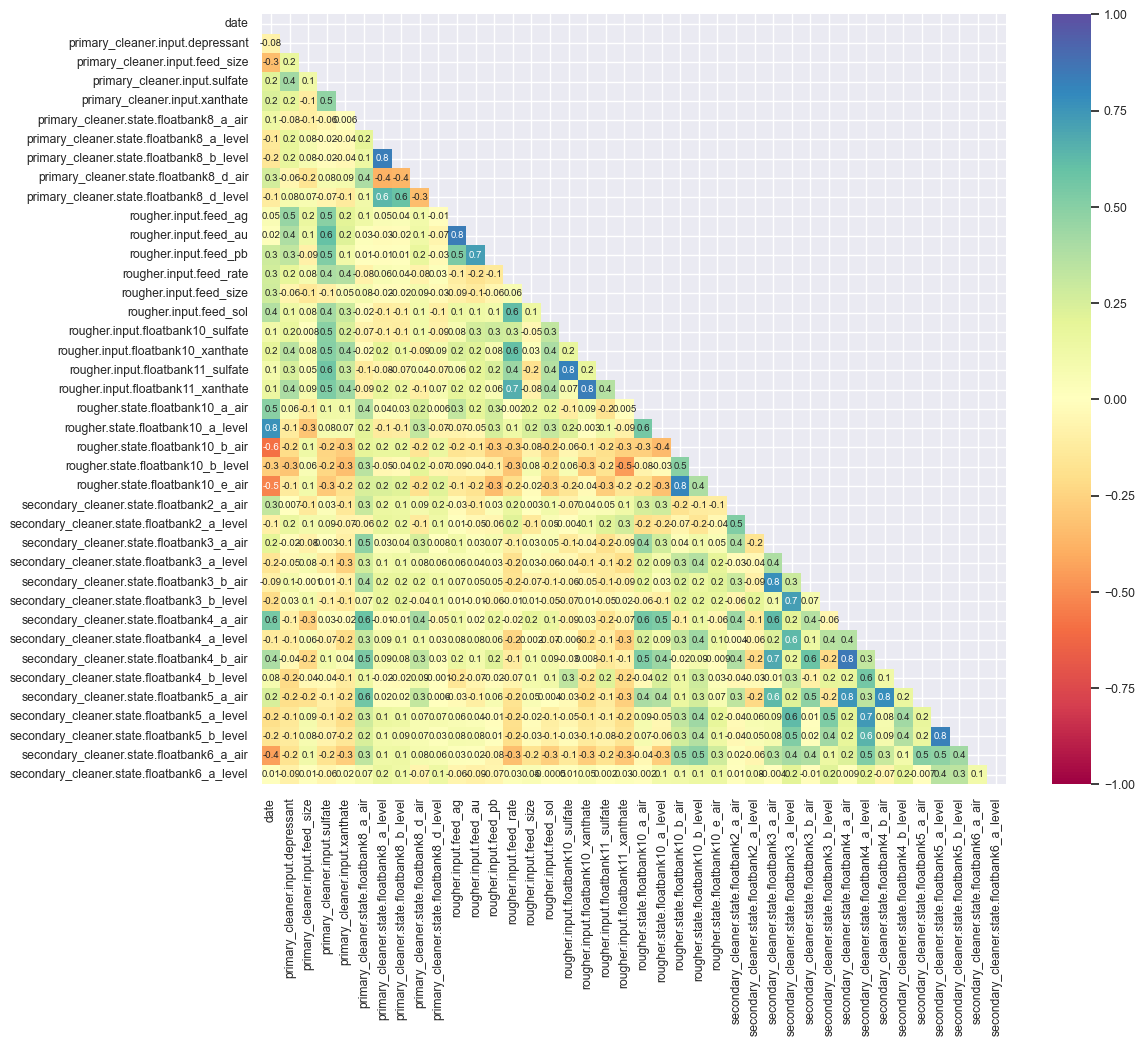

In [16]:
fig, ax = plt.subplots(figsize=(12,10)) 
sns.set (font_scale= 0.8)
matrix = np.triu(d_gold_train[train_col].corr())
sns.heatmap(d_gold_train[train_col].corr(), cmap= 'Spectral', ax=ax, annot = True, fmt='.1g', mask=matrix, \
            vmin=-1, vmax=1, center= 0, annot_kws={"fontsize":7});

Уже лучше, будем использовать эту информацию при обучении модели.

В ходе обзора и предобработки мы:
1. Изменили тип данных столбца date на datetime64 во всех датафреймах
2. Убедились в том, что rougher.output.recovery в обучающей выборке корректно заполняется
3. Убедились в отсутствии дубликатов
4. Выделили и проанализировали признаки, которые не попали в тестовую выборку
5. Убедились в том, что данные в трех датафреймах совпадают по пересекающимся признакам и датам
6. Заполнили недостающие значения признаков
7. Выделили столбцы с сильной корреляцией

## Шаг 2 Анализ данных

### 2.1 Изменение концентрации металлов (Au, Ag, Pb) на различных этапах

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Напишем функцию **concentrate_plot** для построения графиков.  
Использовать попробую sns.boxenplot для текущего пункта и для финальной части анализа -- исследования суммарной концентрации металлов:

In [17]:
def concentrate_plot(df, met_name):
    df_plot=pd.DataFrame()
    if met_name == 'met': # Вариант для П.2.3 "Исследуйте суммарную концентрацию металлов на разных стадиях"
        
# Собираем концентрации металлов в четыре переменные-этапы
        df_plot['Сырьё'] = df['rougher.input.feed_au'] + df['rougher.input.feed_ag'] + \
        df['rougher.input.feed_pb'] + df['rougher.input.feed_sol']

        df_plot['Черновой концентрат'] = df['rougher.output.concentrate_au'] + \
        df['rougher.output.concentrate_ag'] + df['rougher.output.concentrate_pb'] + df['rougher.output.concentrate_sol']

        df_plot['После первой очистки'] = df['primary_cleaner.output.concentrate_au'] + \
        df['primary_cleaner.output.concentrate_ag'] + df['primary_cleaner.output.concentrate_pb'] + \
        df['primary_cleaner.output.concentrate_sol']

        df_plot['Финальный'] = df['final.output.concentrate_au'] + df['final.output.concentrate_ag'] + \
        df['final.output.concentrate_pb'] + df['final.output.concentrate_sol']

        title = 'Изменение концентрации металла (Au + Ag + Pb + Sol) на различных этапах процесса'
        
    else:
# Готовим переменные для фильтрации по тому или иному металлу
        st_0 = 'rougher.input.feed_' + met_name
        st_1 = 'rougher.output.concentrate_' + met_name
        st_2 = 'primary_cleaner.output.concentrate_' + met_name
        st_3 = 'final.output.concentrate_' + met_name
        title = 'Изменение концентрации "' + met_name + '" на различных этапах процесса'
# Собираем датафрейм для графика
        df_plot = df.loc[:,[st_0, st_1, st_2, st_3]].rename(columns={st_0:'Сырьё', st_1:'Черновой концентрат', \
                                          st_2:'После первой очистки', st_3:'Финальный'})
# Это добавил уже после того, как посмотрел графики:
        print('Нулевая концентрация металла', met_name, 'на этапах процесса:')
        print('Сырьё --',df.loc[(df[st_0] == 0), :].shape[0])
        print('Черновой концентрат --', df.loc[(df[st_1] == 0), :].shape[0])
        print('После первой очистки --', df.loc[(df[st_2] == 0), :].shape[0])
        print('Финальный --', df.loc[(df[st_3] == 0), :].shape[0])

    fig, ax = plt.subplots(figsize=(12,5))
# Рисуем график с распределением
    sns.boxenplot(data=df_plot, palette="Spectral",  linewidth=0.5)
# Рисуем график со средними значениями этапа
    plt.plot(range(4), df_plot.median(), marker="o", color="red", markersize=5, linestyle="--")

    ax.set_xlabel('Этап процесса')
    ax.set_ylabel('Концентрация металла')
    ax.set_title(title, fontsize=14)

#### 2.1.1 Изменение концентрации золота (Au) на различных этапах

Нулевая концентрация металла au на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 394
После первой очистки -- 108
Финальный -- 98


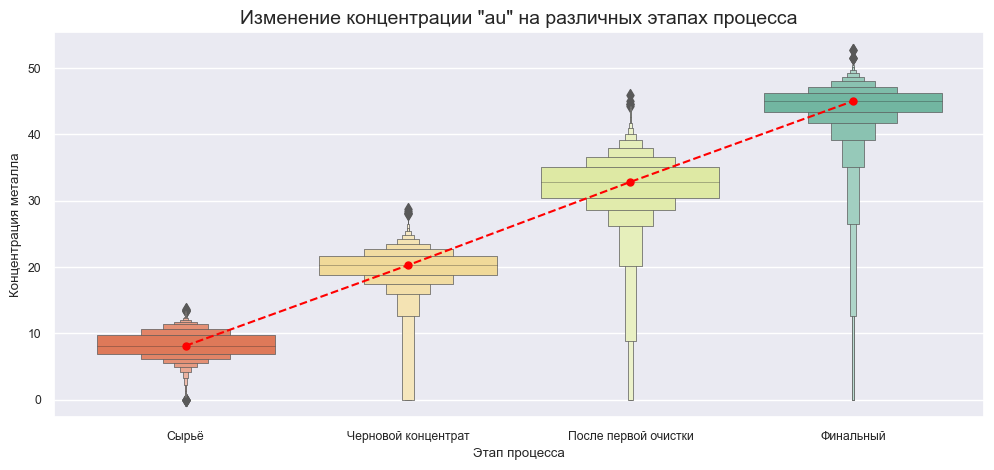

In [18]:
concentrate_plot(d_gold_full, 'au')

Локальный вывод по концентрации золота:
1. Средняя концентрация растет от этапа к этапу **линейно** от 8.1% до 45%
2. К финалу по сравнению с предыдущим этапом процесса данные сильнее сконцентрированы вокруг среднего
3. Есть небольшие выбросы вверх, но основные выбросы ниже средних значений, причем амплитуда растет от этапа к этапу

#### 2.1.2 Изменение концентрации серебра (Ag) на различных этапах

Нулевая концентрация металла ag на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 394
После первой очистки -- 108
Финальный -- 98


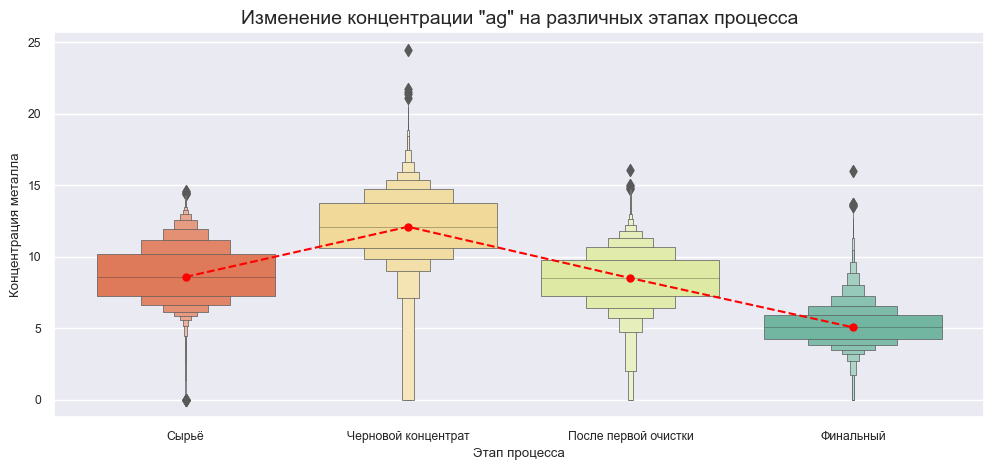

In [19]:
concentrate_plot(d_gold_full, 'ag')

Локальный вывод по концентрации серебра:

1. Средняя концентрация увеличилась с 8.6% до 12% на черновом концентрате, после линейно падала до 5.1% на финальном
2. К финалу по сравнению с предыдущими этапами процесса данные сильнее сконцентрированы вокруг среднего
3. Есть незначительные выбросы как вверх, так и вниз

#### 2.1.3 Изменение концентрации свинца (Pb) на различных этапах

Нулевая концентрация металла pb на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 394
После первой очистки -- 108
Финальный -- 98


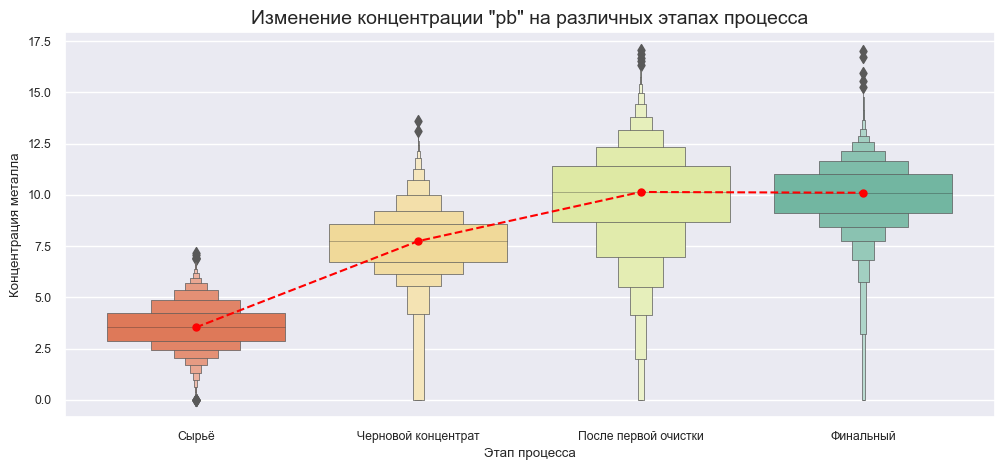

In [20]:
concentrate_plot(d_gold_full, 'pb')

Локальный вывод по концентрации свинца:

1. Средняя концентрация растет первые три этапа с 3.5% до 10.1%, потом стабилизируется на этом значании  
Рост нелинеен, похож на график натурального логарифма, например
2. К финалу по сравнению с предыдущим этапом процесса данные сильнее сконцентрированы вокруг среднего
3. Есть небольшие выбросы вверх, но основные выбросы ниже средних значений, причем амплитуда растет от этапа к этапу, стабилизируясь к финалу

**Небольшое отступление по нулевым концентрациям:**

Количество случаев с нулевой концентрацией металлов стабильно относительно видов металлов. Это интересно. Посмотрим на премере финальной выборки:

In [21]:
d_gold_full.loc[d_gold_full['final.output.concentrate_au'] + d_gold_full['final.output.concentrate_ag'] + \
                d_gold_full['final.output.concentrate_pb'] == 0, \
                ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', \
                'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', \
                'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', \
                 'primary_cleaner.output.concentrate_pb', \
                'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb
516,5.598971,7.407737,1.934178,15.935190,11.803589,7.143475,26.238846,8.986696,6.530607,0.0,0.0,0.0
943,7.786147,8.098125,2.588661,18.682162,10.640168,7.565854,34.564456,8.701237,7.234158,0.0,0.0,0.0
944,7.499248,7.832467,2.435125,18.231121,10.415491,7.367937,34.399450,8.697952,7.119325,0.0,0.0,0.0
945,7.032278,7.600277,2.265148,18.190655,10.197899,7.364725,34.303756,8.921656,6.637383,0.0,0.0,0.0
946,7.021635,7.436860,2.265435,18.194323,9.968103,7.282737,33.956378,9.239378,6.249012,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11553,11.604771,12.464094,5.393215,19.442973,14.424928,8.120457,34.015777,8.415798,10.210094,0.0,0.0,0.0
11554,11.763586,12.726401,5.630816,17.784973,14.028955,8.029784,27.937329,11.517548,11.462232,0.0,0.0,0.0
11754,7.345464,9.398085,2.653756,20.047747,12.043514,9.540977,2.635256,0.634975,0.090132,0.0,0.0,0.0
11755,7.687805,9.812272,2.738460,22.632637,14.639309,6.588981,32.702605,8.735761,7.265347,0.0,0.0,0.0


То есть, на финальном этапе из материи пропал **весь** металл. А раньше был. Причем на этапе сырья был при каждом измерении.
Посмотрим для очистки совести на два оставшихся этапа:

Черновой концентрат:

In [22]:
d_gold_full.loc[d_gold_full['rougher.output.concentrate_au'] + d_gold_full['rougher.output.concentrate_ag'] + \
                d_gold_full['rougher.output.concentrate_pb'] == 0, \
                ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', \
                'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', \
                'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', \
                 'primary_cleaner.output.concentrate_pb', \
                'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb
36,7.114065,7.521974,2.811569,0.0,0.0,0.0,37.633572,8.513177,9.724797,46.614456,4.566664,10.406178
37,7.651522,7.313187,2.973841,0.0,0.0,0.0,37.718947,8.466262,9.780929,46.250638,4.577832,10.691605
38,5.587750,7.934791,1.763437,0.0,0.0,0.0,38.624404,8.092185,9.719728,46.663335,4.591462,10.628846
39,4.752992,7.756881,1.025762,0.0,0.0,0.0,40.086360,7.680496,9.038210,44.015642,5.296830,10.597469
40,5.122801,5.393466,1.824835,0.0,0.0,0.0,33.895014,10.545583,8.209346,40.715973,8.162896,8.877528
...,...,...,...,...,...,...,...,...,...,...,...,...
12134,7.951063,8.576019,2.607144,0.0,0.0,0.0,34.881720,8.978113,10.463460,47.660737,4.909904,9.941006
12135,8.715784,8.640039,2.905023,0.0,0.0,0.0,34.803462,8.951252,10.754766,47.801056,4.797572,9.889303
12136,9.026122,8.769059,3.020251,0.0,0.0,0.0,36.013125,8.377929,11.010672,49.412576,4.329492,9.413122
12137,8.752430,8.705607,2.881386,0.0,0.0,0.0,35.557834,8.599144,11.066215,48.839994,4.317169,9.642271


После первой очистки:

In [23]:
d_gold_full.loc[d_gold_full['primary_cleaner.output.concentrate_au'] + d_gold_full['primary_cleaner.output.concentrate_ag'] + \
                d_gold_full['primary_cleaner.output.concentrate_pb'] == 0, \
                ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', \
                'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', \
                'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', \
                 'primary_cleaner.output.concentrate_pb', \
                'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb
14,6.801254,6.046063,2.777324,18.511902,10.788951,7.537074,0.0,0.0,0.0,42.509402,5.658943,10.436002
17,6.610732,5.599324,2.525838,18.089134,10.958096,7.267608,0.0,0.0,0.0,41.406172,6.118749,10.483007
25,6.524249,5.689557,2.508414,17.583602,11.574823,7.384216,0.0,0.0,0.0,44.059908,5.322681,9.577672
58,7.120089,6.994296,2.875142,18.414367,10.350497,7.456147,0.0,0.0,0.0,45.135616,4.677499,11.304745
61,7.103887,7.844640,2.653501,18.614079,10.585663,7.076596,0.0,0.0,0.0,43.264258,4.821388,10.235502
...,...,...,...,...,...,...,...,...,...,...,...,...
11882,12.296234,12.300870,5.865258,19.980163,14.128605,8.641848,0.0,0.0,0.0,44.838592,6.171409,10.028069
11885,12.088189,12.448347,5.670709,19.971302,13.920325,8.553081,0.0,0.0,0.0,46.458319,5.448963,9.682072
11898,12.107691,13.325236,5.474456,18.482986,13.350315,7.457026,0.0,0.0,0.0,45.294555,6.137303,10.105221
11955,12.290951,13.083709,5.715880,21.658283,15.179420,8.685790,0.0,0.0,0.0,43.902258,6.908167,10.288687


Картина ясная -- металл был в сырье, на определенном этапе процесса он изчезает из материала, но потом возвращается на следующих этапах.  
С одной стороны, эти строки удалять не стоит -- учиться модель на них в этой части не будет, так как этих признаков в тестовой выборке нет. Всё зря, получается.  
С другой -- если измерения поломаны в этих признаках, то рискуем, что они поломаны где-то еще в рамках строки.

Посмотрим, так или иначе, как изменится распределение бех этих строк, в итоге примем решение -- удалять или нет:

Нулевая концентрация металла au на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 0
После первой очистки -- 0
Финальный -- 0
Нулевая концентрация металла ag на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 0
После первой очистки -- 0
Финальный -- 0
Нулевая концентрация металла pb на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 0
После первой очистки -- 0
Финальный -- 0


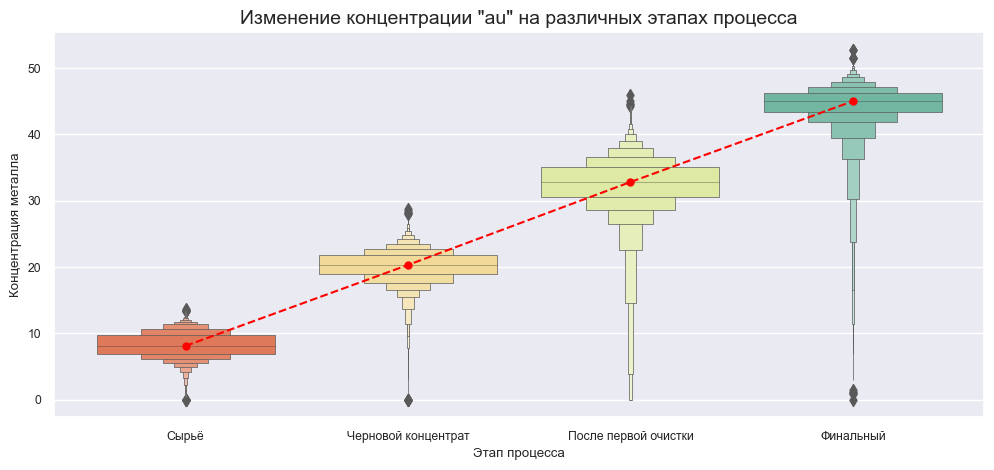

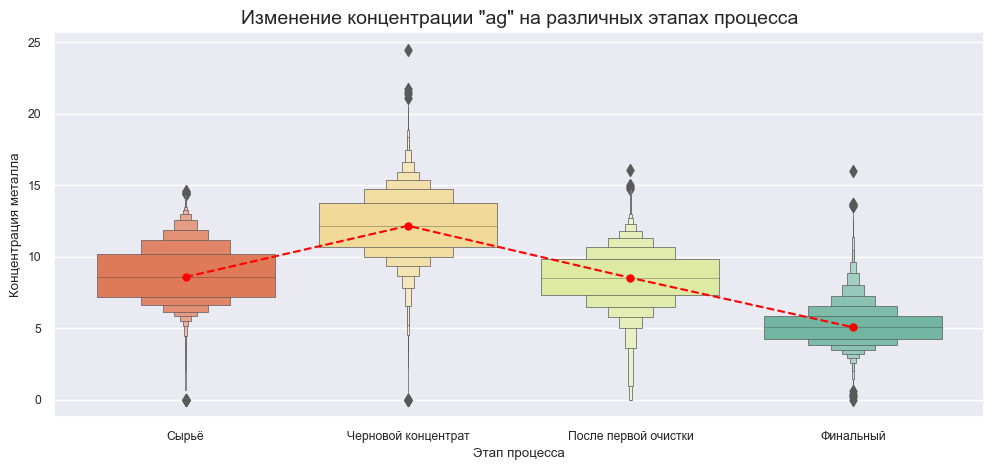

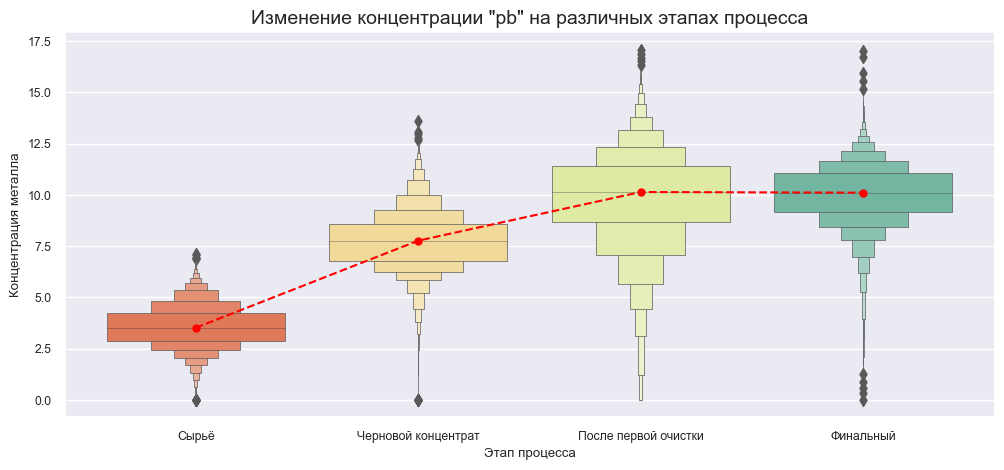

In [24]:
for i in ['au', 'ag', 'pb']:
    concentrate_plot(d_gold_full.loc[(d_gold_full['primary_cleaner.output.concentrate_au'] + \
                                      d_gold_full['primary_cleaner.output.concentrate_ag'] + \
                                      d_gold_full['primary_cleaner.output.concentrate_pb'] > 0) & \
                                         (d_gold_full['rougher.output.concentrate_au'] + \
                                          d_gold_full['rougher.output.concentrate_ag'] + \
                                          d_gold_full['rougher.output.concentrate_pb'] > 0) & \
                                             (d_gold_full['final.output.concentrate_au'] + \
                                              d_gold_full['final.output.concentrate_ag'] + \
                                              d_gold_full['final.output.concentrate_pb'] > 0), :], i)

Графики истончились по краям, как и ожидалось, но глобально картина не изменилась.
Предлагаю все же удалить строки при подготовке данных к обучению.

### 2.2 Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках

Построим соответствующие гистограммы для:
 - rougher.input.feed_size
 - primary_cleaner.input.feed_size

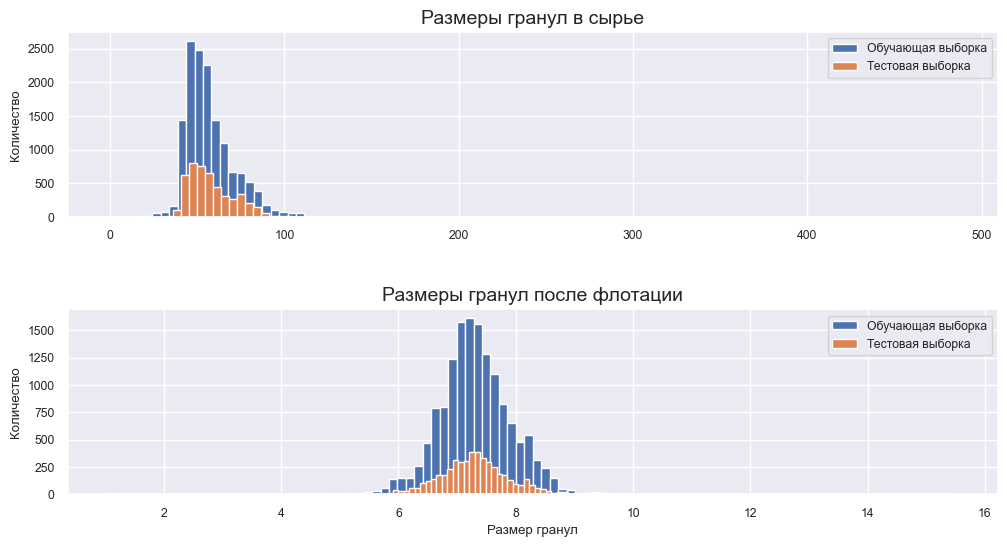

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
axes = ax[0].hist(d_gold_train['rougher.input.feed_size'], bins=100, label='Обучающая выборка')
axes = ax[0].hist(d_gold_test['rougher.input.feed_size'], bins=80, label='Тестовая выборка')
ax[0].set_title('Размеры гранул в сырье', fontsize=14)
ax[0].set_ylabel('Количество')
ax[0].legend(loc='upper right')

axes = ax[1].hist(d_gold_train['primary_cleaner.input.feed_size'], bins=100, label='Обучающая выборка')
axes = ax[1].hist(d_gold_test['primary_cleaner.input.feed_size'], bins=50, label='Тестовая выборка')
ax[1].set_title('Размеры гранул после флотации', fontsize=14)
ax[1].set_xlabel('Размер гранул')
ax[1].set_ylabel('Количество')
ax[1].legend(loc='upper right');

Отфильтруем выбросы, посмотрим внимательнее:

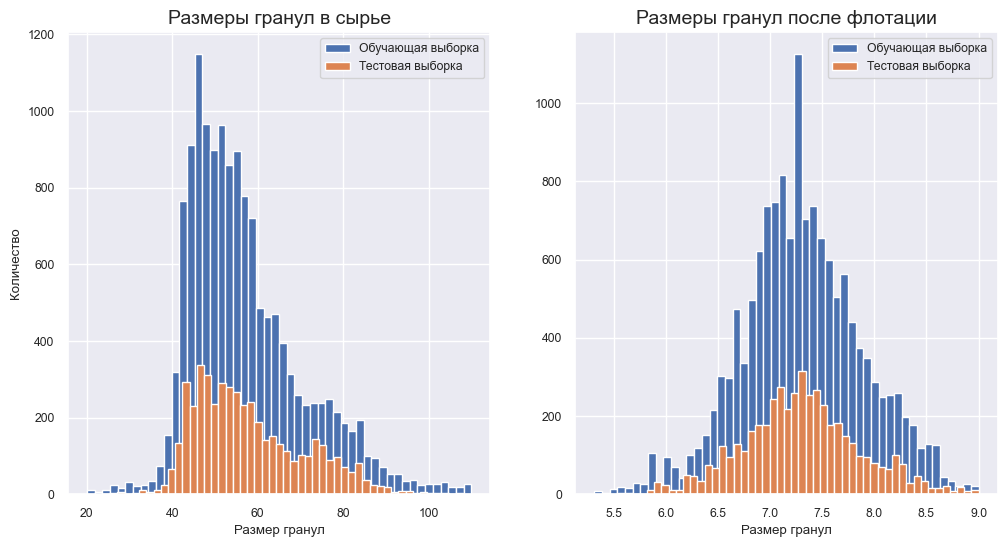

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

axes = ax[0].hist(d_gold_train.loc[(d_gold_train['rougher.input.feed_size'] >= 20) & \
                                   (d_gold_train['rougher.input.feed_size'] <= 110), \
                                   ['rougher.input.feed_size']], bins=50, label='Обучающая выборка')

axes = ax[0].hist(d_gold_test.loc[(d_gold_test['rougher.input.feed_size'] >= 20) & \
                                  (d_gold_test['rougher.input.feed_size'] <= 110), \
                                  ['rougher.input.feed_size']], bins=50, label='Тестовая выборка')
ax[0].set_title('Размеры гранул в сырье', fontsize=14)
ax[0].set_xlabel('Размер гранул')
ax[0].set_ylabel('Количество')
ax[0].legend(loc='upper right')

axes = ax[1].hist(d_gold_train.loc[(d_gold_train['primary_cleaner.input.feed_size'] >= 5) & \
                                   (d_gold_train['primary_cleaner.input.feed_size'] <= 9), \
                                   ['primary_cleaner.input.feed_size']], bins=50, label='Обучающая выборка')

axes = ax[1].hist(d_gold_test.loc[(d_gold_test['primary_cleaner.input.feed_size'] >= 5) & \
                                  (d_gold_test['primary_cleaner.input.feed_size'] <= 9), \
                                  ['primary_cleaner.input.feed_size']], bins=50, label='Тестовая выборка')
ax[1].set_title('Размеры гранул после флотации', fontsize=14)
ax[1].set_xlabel('Размер гранул')
ax[1].legend(loc='upper right');

Все ОК, распределения схожи, рыжие столбики примерно в три раза короче, так и должно быть но посмотрим дополнительно на нормализированную плотность распределения:

#### 2.2.1 Сравнение распределения размеров с помощью плотности их распределения в выборках

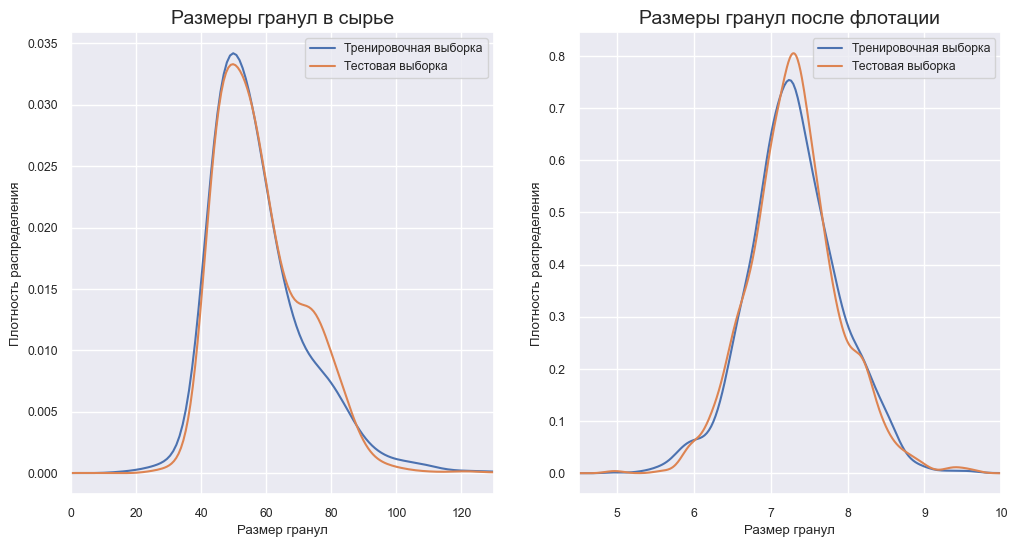

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

d_gold_train.loc[:, ['rougher.input.feed_size']].plot.kde(bw_method=0.2, ax=ax[0], xlim=[0, 130])
d_gold_test.loc[:, ['rougher.input.feed_size']].plot.kde(bw_method=0.2, ax=ax[0], xlim=[0, 130])

ax[0].set_title('Размеры гранул в сырье', fontsize=14)
ax[0].legend(['Тренировочная выборка', 'Тестовая выборка'], loc='upper right')
ax[0].set_xlabel('Размер гранул')
ax[0].set_ylabel('Плотность распределения')

d_gold_train.loc[:, ['primary_cleaner.input.feed_size']].plot.kde(bw_method=0.2, ax=ax[1], xlim=[4.5, 10])
d_gold_test.loc[:, ['primary_cleaner.input.feed_size']].plot.kde(bw_method=0.2, ax=ax[1], xlim=[4.5, 10])

ax[1].set_title('Размеры гранул после флотации', fontsize=14)
ax[1].legend(['Тренировочная выборка', 'Тестовая выборка'], loc='upper right')
ax[1].set_xlabel('Размер гранул')
ax[1].set_ylabel('Плотность распределения');

Стало нагляднее, данные можно брать в работу.

**NB!** Пока копался с данными обратил внимание, что тестовая и тренировочная выборки не перемешаны:

In [28]:
print(d_gold_train.date.max())
print(d_gold_test.date.min())

2017-12-09 13:59:59
2017-12-09 14:59:59


То есть, от общей выборки прост отрезали четверть самых поздних по времени значений.

### 2.3 Исследование суммарной концентрации металлов на разных стадиях

Посмотрим изменение суммарной концентрации металла на выборке без нулевых концентраций:

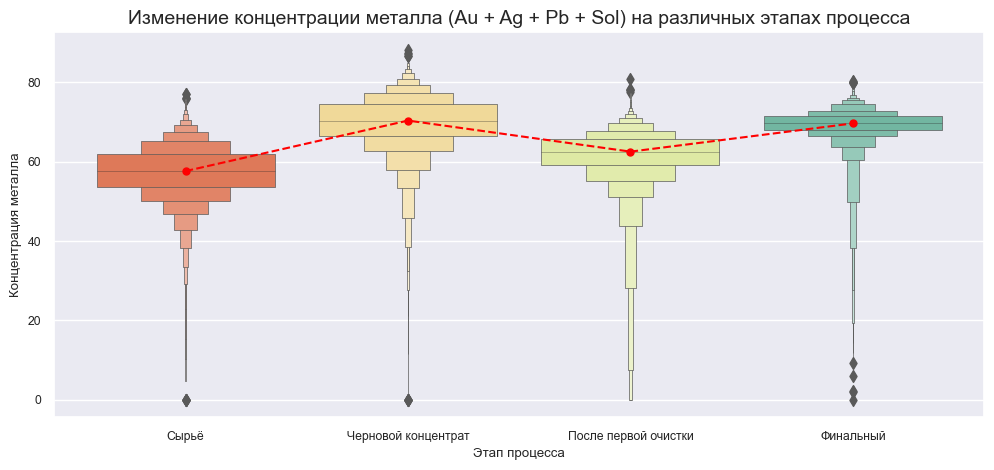

In [29]:
concentrate_plot(d_gold_full.loc[(d_gold_full['primary_cleaner.output.concentrate_au'] + \
                                  d_gold_full['primary_cleaner.output.concentrate_ag'] + \
                                  d_gold_full['primary_cleaner.output.concentrate_pb'] + \
                                  d_gold_full['primary_cleaner.output.concentrate_sol'] > 0) & \
                                         (d_gold_full['rougher.output.concentrate_au'] + \
                                          d_gold_full['rougher.output.concentrate_ag'] + \
                                          d_gold_full['rougher.output.concentrate_pb'] + \
                                          d_gold_full['rougher.output.concentrate_sol'] > 0) & \
                                             (d_gold_full['final.output.concentrate_au'] + \
                                              d_gold_full['final.output.concentrate_ag'] + \
                                              d_gold_full['final.output.concentrate_pb'] + \
                                              d_gold_full['final.output.concentrate_sol'] > 0), :], 'met')

Неожиданная картина.

На протяжении исследования мы видили, что по мере очистки концентрация металллов в основном росла, тут же она колеблется в среднем от 60% до 70%. Разве что, разброс уменьшается.

Подозреваю, что виной влияние четвертого элемента -- sol. Я так и не понял, что это. В периодичесокй таблице в металлах ничего похожего, в статьях про золотодобычу -- тоже. С латыни sol -- солнце, с румынского -- грунт, с хорватского -- соль, с индонезийского -- подошва. Есть вариант, что это не металл совсем, тогда концентрация Au+Ag+Pb будет нелинейно расти с 20% до 60%.

С другой стороны, значения концентрации sol измеряют одновременно с золотом, серебром и свинцом. Скорее всего, тем же прибором, так как отказывает и показывает нулевую концентрацию он в тех же случаях, что и на понятных металлах.

Так или иначе, посмотрим на динамику распределения концентрации sol:

Нулевая концентрация металла sol на этапах процесса:
Сырьё -- 0
Черновой концентрат -- 0
После первой очистки -- 0
Финальный -- 0


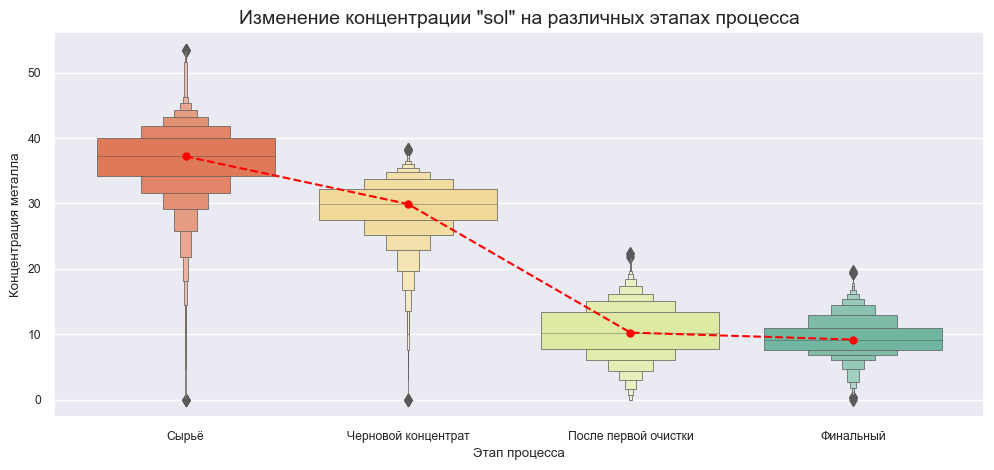

In [30]:
concentrate_plot(d_gold_full.loc[(d_gold_full['primary_cleaner.output.concentrate_au'] + \
                                  d_gold_full['primary_cleaner.output.concentrate_ag'] + \
                                  d_gold_full['primary_cleaner.output.concentrate_pb'] + \
                                  d_gold_full['primary_cleaner.output.concentrate_sol'] > 0) & \
                                         (d_gold_full['rougher.output.concentrate_au'] + \
                                          d_gold_full['rougher.output.concentrate_ag'] + \
                                          d_gold_full['rougher.output.concentrate_pb'] + \
                                          d_gold_full['rougher.output.concentrate_sol'] > 0) & \
                                             (d_gold_full['final.output.concentrate_au'] + \
                                              d_gold_full['final.output.concentrate_ag'] + \
                                              d_gold_full['final.output.concentrate_pb'] + \
                                              d_gold_full['final.output.concentrate_sol'] > 0), :], 'sol')

Да, так и есть, заметное падение на первых двух этапах и стабилизация на последующих этапах компенсирует поведение остальных металлов.

Выводы по исследованию динамики концентрации металлов:
1. Коцентрация колеблется примерно на одном уровне в среднем от 60% до 70%
3. К финалу по сравнению с предыдущими этапами процесса данные сильнее сконцентрированы вокруг среднего
4. Есть небольшие выбросы вверх, но основные выбросы ниже средних значений

## Шаг 3 Построение модели

Для подготовки данных:

1. Удалим строки с нулями на концентрациях

Далее поймем, что нам надо делать **две** модели обучения -- для расчета показателя sMAPE(rougher) и sMAPE(final). А они разные, так как я не могу отдать один и тот же наобор признаков для расчета rougher.output.recovery и final.output.recovery, так как на момент появления rougher.output.recovery по процессу неизвестны значения признаков, которые буду известны когда-то в будущем. А для final.output.recovery мы можем уже весь набор спокойно использовать. Очевидно, гиперпараметры у моделей будут отличаться при таких вводных.

Поэтому мы далее:

2. Сформируем features и target для финальной sMAPE (удалим столбцы, которых нет в тестовой выборке, снесем дату и признаки с высокой корреляцией (см. 1.2.6)
3. Выделим из обучающей и тестовой выборок признаки, которые относятся к rougher.output.recovery (дальнейшие шаги выполняются независимо для двух моделей)
4. Выделим тренировочную и валидационные выборки, проведём маштабирование признаков, проверим результаты
5. На трех моделях (дерево, лес и регрессия) подберем гиперпараметры и проведём кросс-валидацию, выберем лучшее

Но для начала займемся функциями получения sMAPE (**smape_calc**) и Итоговое sMAPE (**itog_smape_calc**):

### 3.1 Реализация функций расчета sMAPE и Итоговое sMAPE

Напомню формулу расчета sMAPE:

$$sMAPE=\frac{1}{N}\sum_{i-1}^{N}\frac{|y_i-\widehat{y_i}|}{(|y_i|+|\widehat{y_i}|)/2}*100\%,$$
где:
   - $y_i$ — значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество  
   - $\widehat{y_i}$ — значение предсказания для объекта с порядковым номером i, например, в тестовой выборке  
   - $N$ — количество объектов в выборке

In [31]:
def smape_calc(true, pred):
    return (abs(true - pred) / ((abs(true) + abs(pred)) / 2)).mean() * 100

Напомню форму расчета Итоговое sMAPE:

$$Итоговое\ sMAPE=25\%*sMAPE(rougher)\ +\ 75\%*sMAPE(final),$$
    где:
   - $rougher$ — эффективность обогащения чернового концентрата
   - $final$ — эффективность финального чернового концентрата

In [32]:
def itog_smape_calc(smape_r, smape_f):
    return 0.25 * smape_r + 0.75 * smape_f

### 3.2 Подготовка данных для модели

Функция **kill_zero** для удаления строк с нулями на концентрациях:

In [33]:
def kill_zero(df):
    return df.loc[(df['primary_cleaner.output.concentrate_au'] + \
                   df['primary_cleaner.output.concentrate_ag'] + \
                   df['primary_cleaner.output.concentrate_pb'] > 0) & \
                  (df['rougher.output.concentrate_au'] + \
                   df['rougher.output.concentrate_ag'] + \
                   df['rougher.output.concentrate_pb'] > 0) & \
                  (df['final.output.concentrate_au'] + \
                   df['final.output.concentrate_ag'] + \
                   df['final.output.concentrate_pb'] > 0), :]

#### 3.2.1 Режем строки с нулями во всех датафреймах

In [34]:
d_gold_full = kill_zero(d_gold_full) # фильтруем полную выборку
d_gold_train = kill_zero(d_gold_train) # фильтруем тренировочную выборку
d_gold_test = d_gold_test.query('date in @d_gold_full.date') # фильтруем тестовую выборку. В ней нет интересных нам признаков, 
                                                #поэтому удаляем те строки, которые удалили в d_gold_full

print(d_gold_full.shape)
print(d_gold_train.shape)
print(d_gold_test.shape)

(18848, 87)
(13988, 87)
(4860, 53)


Как видим, из тестовой выборки ничего не ушло. Но мы знаем, что тестовая выборка получена отделением самых поздних измерений (см. 2.2). Судя по всему, измерительный прибор починили, и он перестал выдавать нули на концентрации металлов.

#### 3.2.2 Готовим данные для расчета sMAPE (final и rougher)

##### 3.2.2.1 Формирование тестового таргета для куратора

In [35]:
rougher_test_target_curator = d_gold_test.merge(right=d_gold_full.loc[:, ['date', 'rougher.output.recovery']], on='date')\
['rougher.output.recovery'].reset_index(drop='True').reset_index(drop='True')

final_test_target_curator = d_gold_test.merge(right=d_gold_full.loc[:, ['date', 'final.output.recovery']], on='date')\
['final.output.recovery'].reset_index(drop='True')

##### 3.2.2.2 Выделение features и target:

Выделяем features и target:

Для расчета sMAPE(final)

In [36]:
final_features = d_gold_train.loc[:, train_col].drop('date', axis=1) # Напомню, в train_col лежат столбцы, 
                                                    #которые есть и в test, и в train, но без признаков с к-том корреляции > 0.9
final_test_features = d_gold_test.loc[:, train_col].drop('date', axis=1)
final_target = d_gold_train['final.output.recovery']
final_test_target = d_gold_full.query('date in @d_gold_test.date')['final.output.recovery'].reset_index(drop='True')
print(final_features.shape)
print(final_target.shape)
print(final_test_features.shape)
print(final_test_target.shape)
display((final_test_target - final_test_target_curator).sort_values(ascending=False).head(3))

(13988, 39)
(13988,)
(4860, 39)
(4860,)


0       0.0
3246    0.0
3244    0.0
Name: final.output.recovery, dtype: float64

Для расчета sMAPE(rougher)

In [37]:
rougher_features = final_features.filter(like='rougher.')
rougher_test_features = final_test_features.filter(like='rougher.')
rougher_target = d_gold_train['rougher.output.recovery']
rougher_test_target = d_gold_full.query('date in @d_gold_test.date')['rougher.output.recovery'].reset_index(drop='True')

print(rougher_features.shape)
print(rougher_target.shape)
print(rougher_test_features.shape)
print(rougher_test_target.shape)
display((rougher_test_target - rougher_test_target_curator).sort_values().sort_values(ascending=False).head(3))

(13988, 15)
(13988,)
(4860, 15)
(4860,)


0     0.0
19    0.0
36    0.0
Name: rougher.output.recovery, dtype: float64

#### 3.2.3 Обучение и подбор модели (Hold-out)

Определим функцию **data_prep**, которая:
1. Выделяет тренировочную и валидационную выборку
2. Делает скалирование признаков

In [38]:
def data_prep(features, target):
    
# Выделяем тренировочную и валидационную выборки:
    features_train, features_valid, target_train, target_valid =\
    train_test_split(features, target, test_size=0.25, random_state=RAND_FIX)

    print('features_train:', features_train.shape, ' target_train:', target_train.shape)
    print('features_valid:', features_valid.shape, ' target_valid:', target_valid.shape, '\n')

# Проводим масштабирование:
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train.loc[:, :] = scaler.transform(features_train.loc[:, :])
    features_valid.loc[:, :] = scaler.transform(features_valid.loc[:, :])
    
# Визуализация результатов
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    ax = target_train.hist(ax=axes[0], bins=30)
    ax = target_valid.hist(ax=axes[1], bins=30)
    
    axes[0].set_title('target_train')
    axes[1].set_title('target_valid')
    axes[0].set_ylabel('Частота встречающихся значений')
    axes[0].set_xlabel('Значение recovery')
    axes[1].set_xlabel('Значение recovery')
    
    return features_train.reset_index(drop=True), features_valid.reset_index(drop=True), \
target_train.reset_index(drop=True), target_valid.reset_index(drop=True)

features_train: (10491, 39)  target_train: (10491,)
features_valid: (3497, 39)  target_valid: (3497,) 



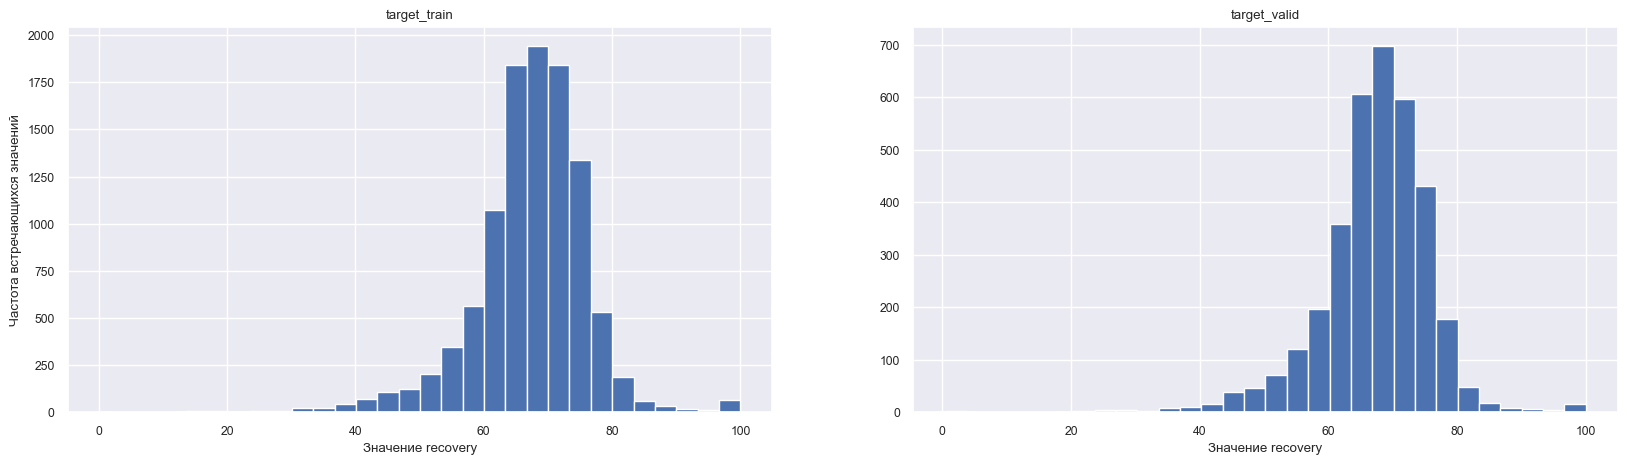

In [39]:
features_train_final, features_valid_final, target_train_final, target_valid_final = data_prep(final_features, final_target)

features_train: (10491, 15)  target_train: (10491,)
features_valid: (3497, 15)  target_valid: (3497,) 



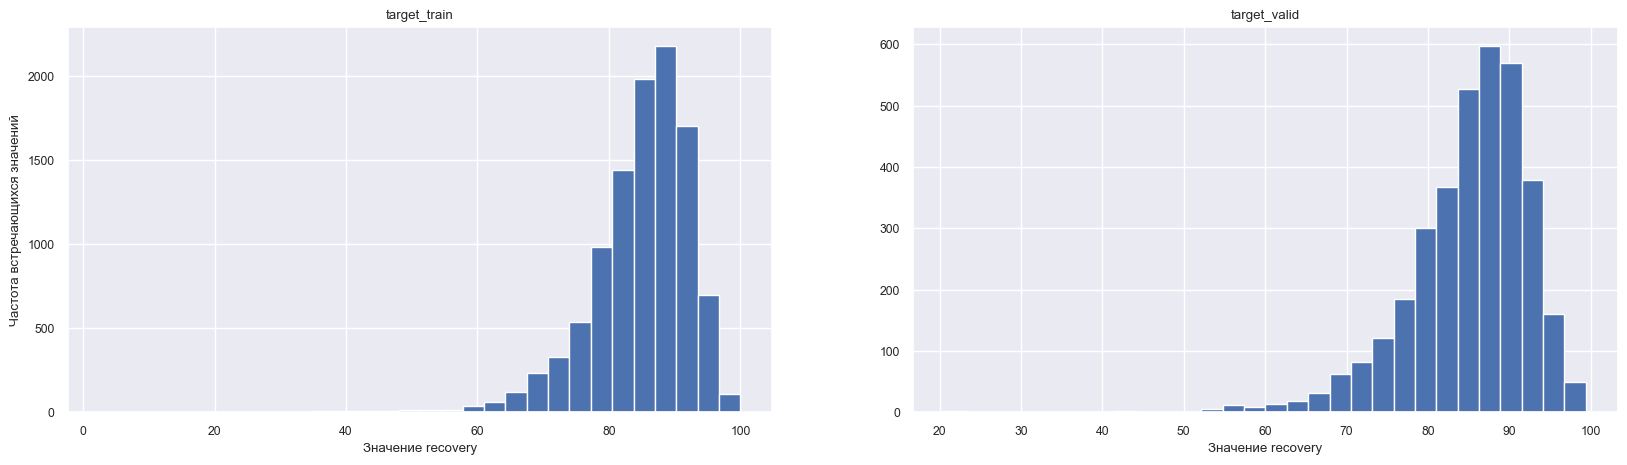

In [40]:
features_train_rougher, features_valid_rougher, target_train_rougher, target_valid_rougher = \
data_prep(rougher_features, rougher_target)

Визуально распредения схожи с поправкой на масштаб, количество строк-столбцов такое, как предполагалось.  
Выборки считаем готовыми.

Все необходимые приготовления данных завершены, обучим три модели, подберем гиперпараметры, подберем для каждой
Модели:
- RandomForestRegressor
- DecisionTreeRegressor
- LinearRegression

Определим функцию **train_for_rmse**, которая принимает тренировочную и валидационную выборки, подбирает гиперпараметры для моделей, возвращает модель с лучшим sMAPE (и соответствующее значение sMAPE):

In [41]:
def train_for_rmse(f_train, t_train, f_valid, t_valid, r_f=''):
    
# Определим результирующие параметры для моделей:
# f -- случайный лес
# t -- дерево решений
# l -- линейная регрессия
    
    best_model_for_f = None
    best_result_for_f = 50
    best_est_for_f = 0
    best_depth_for_f = 0
    
    best_model_for_t = None
    best_result_for_t = 50
    best_depth_for_t = 0
    
    best_model_for_l = None
    best_result_for_l = 50

# Эта секция будет работать при MODE == 'check' -- параметры там предподставлены уже
    if r_f == 'r': # Гиперпараметры для sMAPE(rougher)
        start_time = time.time()
        best_model_for_f = RandomForestRegressor(random_state=RAND_FIX, n_estimators=120, max_depth=32)  # Инициируем модель
        best_model_for_f.fit(f_train, t_train)     # Учим модель
        end_time = time.time()
        pred_val_f = best_model_for_f.predict(f_valid)
        best_result_for_f = smape_calc(t_valid, pred_val_f)
        best_est_for_f = 120
        best_depth_for_f = 32
        est_time_for_f = end_time - start_time
    elif r_f == 'f': # Гиперпараметры для sMAPE(final)
        start_time = time.time()
        best_model_for_f = RandomForestRegressor(random_state=RAND_FIX, n_estimators=180, max_depth=32)  # Инициируем модель
        best_model_for_f.fit(f_train, t_train)     # Учим модель
        end_time = time.time()
        pred_val_f = best_model_for_f.predict(f_valid)
        best_result_for_f = smape_calc(t_valid, pred_val_f)
        best_est_for_f = 290
        best_depth_for_f = 44
        est_time_for_f = end_time - start_time
# Конец секции с пердзаполнением
    # Цикл для подборки глубины и количества деревьев случайного леса:
    else:
        for est in range(10, 300, 10):
            for depth in range (4, 50, 2):
                start_time = time.time()
                model = RandomForestRegressor(random_state=RAND_FIX, n_estimators=est, max_depth=depth)  # Инициируем модель
                model.fit(f_train, t_train)     # Учим модель
                end_time = time.time()
                pred_val_f = model.predict(f_valid)
                result = smape_calc(t_valid, pred_val_f)
                if result < best_result_for_f:
                    best_model_for_f = model
                    best_result_for_f = result
                    best_est_for_f = est
                    best_depth_for_f = depth
                    est_time_for_f = end_time - start_time
    
    # Цикл для подборки глубины дерева решений:  
    for depth in range(4, 31):
        start_time = time.time()
        model = DecisionTreeRegressor(max_depth=depth, random_state=RAND_FIX) # Инициируем модель
        model.fit(f_train, t_train)    # Учим модель
        end_time = time.time()
        pred_val_t = model.predict(f_valid)
        result = smape_calc(t_valid, pred_val_t)
        if result < best_result_for_t:
            best_result_for_t = result
            est_time_for_t = end_time - start_time
            best_depth_for_t = depth
            best_model_for_t = model
            
    if best_result_for_t < best_result_for_f:
        the_best_result = best_result_for_t
        the_best_model = best_model_for_f
    else:
        the_best_result = best_result_for_f
        the_best_model = best_model_for_f        

    # Линейная регрессия:
    start_time = time.time()
    model = LinearRegression()  # Инициируем модель
    model.fit(f_train, t_train)        # Учим модель
    end_time = time.time()
    pred_val_l = model.predict(f_valid)
    result = smape_calc(t_valid, pred_val_l)
    if result < best_result_for_l:
        best_result_for_l = result
        est_time_for_l = end_time - start_time
        best_model_for_l = model
        
    if best_result_for_l < the_best_result:
        the_best_result = best_result_for_l
        the_best_model = best_model_for_l


# Отображаем результаты в табличке:
    d_res = {'Глубина':[best_depth_for_f, best_depth_for_t, np.nan],\
             'Кол-во деревьев':[best_est_for_f, np.nan, np.nan],\
             'Время обучения':[est_time_for_f, est_time_for_t, est_time_for_l],\
             'SMAPE score':[best_result_for_f, best_result_for_t, best_result_for_l]}
    df_res = pd.DataFrame(index=['Случайный лес', 'Дерево решений', 'Линейная регрессия'], \
                        data=d_res)
    
    print('Результаты исследования моделей:')
    display(df_res)
    print('\n\n')
    
    return the_best_result, the_best_model

Найдем оптимальную модель для расчета sMAPE(rougher):

In [42]:
if MODE == 'check':
    rougher_smape, rougher_model = \
    train_for_rmse(features_train_rougher, target_train_rougher, features_valid_rougher, target_valid_rougher, 'r')
else:
    rougher_smape, rougher_model = train_for_rmse(features_train_rougher, target_train_rougher, features_valid_rougher, \
                                              target_valid_rougher)

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,SMAPE score
Случайный лес,32.0,120.0,14.810103,2.626851
Дерево решений,14.0,NaN,0.161091,3.562583
Линейная регрессия,NaN,NaN,0.015895,4.930066


Найдем оптимальную модель для расчета sMAPE(final):

In [43]:
if MODE == 'check':
    final_smape, final_model = \
    train_for_rmse(features_train_final, target_train_final, features_valid_final, target_valid_final, 'f')
else:
    final_smape, final_model = \
    train_for_rmse(features_train_final, target_train_final, features_valid_final, target_valid_final)

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,SMAPE score
Случайный лес,44.0,290.0,65.206876,5.808577
Дерево решений,9.0,NaN,0.313991,7.420587
Линейная регрессия,NaN,NaN,0.013527,8.105750


Расчитаем итоговое значение sMAPE:

In [44]:
print('Итоговое значение sMAPE на валидационной выборке: {:.3f}'.format(itog_smape_calc(rougher_smape, final_smape)))

Итоговое значение sMAPE на валидационной выборке: 5.013


#### 3.2.4 Обучение и подбор модели (Cross-validation)

Скалируем тренировочную выборку:

Для rougher_features:

In [45]:
scaler_rougher = StandardScaler()
scaler_rougher.fit(rougher_features)

rougher_features.loc[:, :] = scaler_rougher.transform(rougher_features.loc[:, :])

Для final_features:

In [46]:
scaler_final = StandardScaler()
scaler_final.fit(final_features)

final_features.loc[:, :] = scaler_final.transform(final_features.loc[:, :])

Делаем скоринг для GridSearchCV

In [47]:
smape_scoring = make_scorer(smape_calc, greater_is_better=False)

Определим функцию **train_for_rmse_scorer**, которая принимает тренировочную выборку, подбирает гиперпараметры для моделей с помощью GridSearchCV, возвращает модель с лучшим sMAPE (и соответствующее значение sMAPE):

In [48]:
def train_for_rmse_scorer(features, target, r_f):
    
#     Задаем правила подбора параметров моделей для GridSearchCV
    if r_f == 'r':
        param_for_f = {'n_estimators' : [180], 'max_depth' : [8], 'random_state' : [RAND_FIX]}
        param_for_t = {'max_depth': [7], 'random_state' : [RAND_FIX]}
    elif r_f == 'f':
        param_for_f = {'n_estimators' : [30], 'max_depth' : [4], 'random_state' : [RAND_FIX]}
        param_for_t = {'max_depth': [4], 'random_state' : [RAND_FIX]}
    else:
        param_for_f = {'n_estimators' : range(10, 301, 10), 'max_depth' : range(4, 51, 2), 'random_state' : [RAND_FIX]}
        param_for_t = {'max_depth': range(4, 51), 'random_state' : [RAND_FIX]}
    param_for_l = {}
    
#     Инициируем модели
    grid_model_f = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_for_f, scoring=smape_scoring)
    grid_model_t = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_for_t, scoring=smape_scoring)
    grid_model_l = GridSearchCV(estimator=LinearRegression(), param_grid=param_for_l, scoring=smape_scoring)
    
#     Учим и выбираем лучшую
    grid_model_f.fit(features, target)
    
    grid_model_t.fit(features, target)
    
    if abs(grid_model_f.best_score_) < abs(grid_model_t.best_score_):
        the_best_result = abs(grid_model_f.best_score_)
        the_best_model = grid_model_f
    else:
        the_best_result = abs(grid_model_t.best_score_)
        the_best_model = grid_model_t
        
    grid_model_l.fit(features, target)
    
    if abs(grid_model_l.best_score_) < the_best_result:
        the_best_result = abs(grid_model_l.best_score_)
        the_best_model = grid_model_l
    
#     Отображаем результаты
    d_res = {'Глубина':[grid_model_f.best_params_['max_depth'], grid_model_t.best_params_['max_depth'], np.nan],\
             'Кол-во деревьев':[grid_model_f.best_params_['n_estimators'], np.nan, np.nan],\
             'Время обучения':[grid_model_f.refit_time_, grid_model_t.refit_time_, grid_model_l.refit_time_],\
             'SMAPE score':[abs(grid_model_f.best_score_), abs(grid_model_t.best_score_), abs(grid_model_l.best_score_)]}
    df_res = pd.DataFrame(index=['Случайный лес', 'Дерево решений', 'Линейная регрессия'], \
                        data=d_res) 
    
    print('Результаты исследования моделей:')
    display(df_res)
    print('\n\n')
           
    return the_best_result, the_best_model

Найдем оптимальную модель для расчета sMAPE(rougher):

In [49]:
if MODE == 'check':
    rougher_smape_scorer, rougher_model_scorer = train_for_rmse_scorer(rougher_features, rougher_target, 'r')
else:
    rougher_smape_scorer, rougher_model_scorer = train_for_rmse_scorer(rougher_features, rougher_target)

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,SMAPE score
Случайный лес,8.0,180.0,15.832370,6.214349
Дерево решений,7.0,NaN,0.130511,6.605504
Линейная регрессия,NaN,NaN,0.003000,6.420275


Найдем оптимальную модель для расчета sMAPE(final):

In [50]:
if MODE == 'check':
    final_smape_scorer, final_model_scorer = train_for_rmse_scorer(final_features, final_target, 'f')
else:
    final_smape_scorer, final_model_scorer = train_for_rmse_scorer(final_features, final_target)

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,SMAPE score
Случайный лес,4.0,30.0,3.755128,9.121761
Дерево решений,4.0,NaN,0.199018,9.582630
Линейная регрессия,NaN,NaN,0.008000,9.709256


Расчитаем итоговое значение sMAPE:

In [51]:
print('Итоговое значение sMAPE на валидационной выборке: {:.3f}'.\
      format(itog_smape_calc(rougher_smape_scorer, final_smape_scorer)))

Итоговое значение sMAPE на валидационной выборке: 8.395


## Шаг 4 Тестирование модели

### 4.1 Тестирование модели (Hold-out)

Тестовую выборку мы подготовили в п. 3.2.3  
Расчитаем sMAPE(rougher) и sMAPE(final)

Проведем масштабирование тестовой выборки  
Сначала я положил этот этап внутрь data_prep после разделения тренировочной выборки на тернировочную и валидационную. В теории так должно быть правильно (наверное), но на практике маловероятно у нас будет доступно именно такое распределение. Оно определяется константой RAND_FIX, не думаю, что в распоряжении у тех, кто будет использовать модель, будет подобная информация.

In [52]:
rougher_test_features.loc[:, :] = scaler_rougher.transform(rougher_test_features.loc[:, :])

final_test_features.loc[:, :] = scaler_final.transform(final_test_features.loc[:, :])

Произведем предсказание, вычислим sMAPE(rougher) и sMAPE(final):

In [53]:
pred_rougher_test = rougher_model.predict(rougher_test_features)
rougher_smape_test = smape_calc(rougher_test_target, pred_rougher_test)
print('sMAPE(rougher) на тесте: {:.2f}'.format(rougher_smape_test))

pred_final_test = final_model.predict(final_test_features)
final_smape_test = smape_calc(final_test_target, pred_final_test)
print('sMAPE(final) на тесте: {:.2f}'.format(final_smape_test))

sMAPE(rougher) на тесте: 2.97
sMAPE(final) на тесте: 6.33


Вычислим итоговое значение sMAPE:

In [54]:
print('Итоговое значение sMAPE на тестовой выборке: {:.3f}'.format(itog_smape_calc(rougher_smape_test, final_smape_test)))

Итоговое значение sMAPE на тестовой выборке: 5.491


### 4.2 Тестирование модели (Cross-validation)

Произведем предсказание, вычислим sMAPE(rougher) и sMAPE(final):

In [55]:
pred_rougher_test_scorer = rougher_model_scorer.predict(rougher_test_features)
rougher_smape_test_scorer = smape_calc(rougher_test_target, pred_rougher_test_scorer)
print('sMAPE(rougher) на тесте для варианта со scorer: {:.2f}'.format(rougher_smape_test_scorer))

pred_final_test_scorer = final_model_scorer.predict(final_test_features)
final_smape_test_scorer = smape_calc(final_test_target, pred_final_test_scorer)
print('sMAPE(final) на тесте для варианта со scorer: {:.2f}'.format(final_smape_test))

sMAPE(rougher) на тесте для варианта со scorer: 3.64
sMAPE(final) на тесте для варианта со scorer: 6.33


Вычислим итоговое значение sMAPE:

In [56]:
print('Итоговое значение sMAPE на тестовой выборке для варианта со scorer: {:.3f}'\
      .format(itog_smape_calc(rougher_smape_test_scorer, final_smape_test_scorer)))

Итоговое значение sMAPE на тестовой выборке для варианта со scorer: 6.663


## Шаг 5 Проверка модели на адекватность

Првоерять будем с помощью коэффициента детерминации ($R^2$).
Больше нуля получим если, значит наша модель получилась лучше, чем константная, которая всегда предсказывает среднее значение.

In [57]:
r2_score(rougher_test_target, pred_rougher_test)

0.6462181496483363

In [58]:
r2_score(final_test_target, pred_final_test)

0.41952157740624507

Вычислим также $R^2$ для варианта c Cross-validation:

In [59]:
r2_score(rougher_test_target, pred_rougher_test_scorer)

0.5577470276029852

In [60]:
r2_score(final_test_target, pred_final_test_scorer)

0.23983763467276797

Значение $R^2$ для rougher.output.recovery на тестовой выборке == 0.65  
Значение $R^2$ для final.output.recovery на тестовой выборке == 0.42

Значение $R^2$ для rougher.output.recovery на тестовой выборке для варианта со scorer == 0.56  
Значение $R^2$ для final.output.recovery на тестовой выборке для варианта со scorer == 0.24

Это значительно лучше константной модели, что говорит о сравнительной адекватности наших моделей.

### 5.1 Демонстрация сравнения с константной моделью

Для наглядности расчитаем sMape на константной моедели и сравним с нашими результатами:

In [61]:
rougher_dummy_model = DummyRegressor() #Инициация (rougher)
rougher_dummy_model.fit(rougher_features, rougher_target) #Обучение на тренировочной выборке (rougher)
rougher_dummy_pred = rougher_dummy_model.predict(rougher_test_features) 
rougher_dummy_smape = smape_calc(rougher_test_target, rougher_dummy_pred)

final_dummy_model = DummyRegressor() #Инициация (final)
final_dummy_model.fit(final_features, final_target) #Обучение на тренировочной выборке (final)
final_dummy_pred = final_dummy_model.predict(final_test_features)
final_dummy_smape = smape_calc(final_test_target, final_dummy_pred)

print('sMAPE(rougher) на тесте для константной модели: {:.2f}'.format(rougher_dummy_smape))
print('sMAPE(final) на тесте для константной модели: {:.2f}'.format(final_dummy_smape))
print('Итоговый sMAPE на тесте для константной модели: {:.2f}'.format(itog_smape_calc(rougher_dummy_smape, final_dummy_smape)))

sMAPE(rougher) на тесте для константной модели: 6.11
sMAPE(final) на тесте для константной модели: 9.26
Итоговый sMAPE на тесте для константной модели: 8.47


## Общий вывод

В ходе исследования:

Построены и обучены на имеющихся данных модели, которые должны предсказать коэффициент восстановления золота из золотосодержащей руды.  
Модели помогут оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  

То есть:

1. Изучены данные из трех файлов:
    - gold_industry_train.csv — обучающая выборка
    - gold_industry_test.csv — тестовая выборка
    - gold_industry_full.csv — исходные данные  
2. Проверен расчет эффективности обогащения
3. Проанализированы признаки, которые недоступны в тестовой выборке, и завершена предобработка данных
4. Проанализированы концентрации металлов и размер гранул на различных этапах
5. Построены модели для вычисления итоговой sMAPE

### Итоги исследования:

1. **Рекомендации в части данных**  
* Обнаружены аномалии в концентрации металлов -- обнаружено около шестиста случаев нулевых концентраций одновременно повсем металлам на том или ином этапе процесса. Рекомендую исследовать процесс измерения или передачи данных при измерении

2. **Результаты исследования**
* **Анализ данных**
    + Изменение концентрации **золота (Au)** на различных этапах
        - Средняя концентрация растет от этапа к этапу линейно от 8.1% до 45%
        - К финалу по сравнению с предыдущим этапом процесса данные сильнее сконцентрированы вокруг среднего
        - Есть небольшие выбросы вверх, но основные выбросы ниже средних значений, причем амплитуда растет от этапа к этапу
    + Изменение концентрации **серебра (Ag)** на различных этапах
        - Средняя концентрация увеличилась с 8.6% до 12% на черновом концентрате, после линейно падала до 5.1% на финальном
        - К финалу по сравнению с предыдущими этапами процесса данные сильнее сконцентрированы вокруг среднего
        - Есть незначительные выбросы как вверх, так и вниз
    + Изменение концентрации **свинца (Pb)** на различных этапах
        - Средняя концентрация растет первые три этапа с 3.5% до 10.1%, потом стабилизируется на этом значании
        - Рост нелинеен, похож на шрафик натурального логарифма, например
        - К финалу по сравнению с предыдущим этапом процесса данные сильнее сконцентрированы вокруг среднего
        - Есть небольшие выбросы вверх, но основные выбросы ниже средних значений, причем амплитуда растет от этапа к этапу, стабилизируясь к финалу
     + Сравнение распределения **размеров гранул исходного сырья на обучающей и тестовой выборках**
        - Распределения схожи, данные были взяты в работу
        - Обратил внимание, что тестовая и тренировачная выборки не перемешаны, от общей выборки отрезали четверть самых поздних по времени значений
     + Исследование **суммарной концентрации металлов** на разных стадиях
        - Коцентрация колеблется примерно на одном уровне колеблется в среднем от 60% до 70%
        - К финалу по сравнению с предыдущими этапами процесса данные сильнее сконцентрированы вокруг среднего
        - Есть небольшие выбросы вверх, но основные выбросы ниже средних значений
* **Построение и тестирование модели (Hold-out)**
    + Для расчета итоговой sMAPE были выбраны модели:
        - **RandomForestRegressor(n_estimators=120, max_depth=32)** для расчета **sMAPE(rougher)**
        - **RandomForestRegressor(n_estimators=290, max_depth=44)** для расчета **sMAPE(final)**
    + На тестовой выборке получены значения:
        - sMAPE(rougher) == **2.97**
        - sMAPE(final) == **6.33**
        - Итоговое sMAPE == **5.491**
    + Модель является адекватной:
        - Значение $R^2$ для rougher.output.recovery на тестовой выборке == **0.65**  
        - Значение $R^2$ для final.output.recovery на тестовой выборке == **0.42**
        
* **Построение и тестирование модели (Cross-validation)**
    + Для расчета итоговой sMAPE были выбраны модели:
        - **RandomForestRegressor(n_estimators=180, max_depth=8)** для расчета **sMAPE(rougher)**
        - **RandomForestRegressor(n_estimators=30, max_depth=4)** для расчета **sMAPE(final)**
    + На тестовой выборке получены значения:
        - sMAPE(rougher) == **3.64**
        - sMAPE(final) == **6.33**
        - Итоговое sMAPE == **6.663**
    + Модель является адекватной:
        - Значение $R^2$ для rougher.output.recovery на тестовой выборке == **0.56**  
        - Значение $R^2$ для final.output.recovery на тестовой выборке == **0.24**
* **Полученные результаты лучше, чем результаты константной модели:**
     + sMAPE(rougher) на тесте для константной модели == **6.11**
     + sMAPE(final) на тесте для константной модели == **9.26**
     + Итоговый sMAPE на тесте для константной модели == **8.47**